### Import/Install Libraries

In [2]:
import tensorflow as tf
import keras
import xgboost as xgb
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib
import os
import matplotlib.pyplot as plt 
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

2024-04-04 20:55:56.335881: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 20:55:56.335958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 20:55:56.337171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 20:55:56.344537: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)

TensorFlow: 2.15.0
Keras: 2.15.0


### Configuration (from keras starter notebook)

In [4]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [224, 224]  # Input image size
    epochs = 12 # Training epochs
    batch_size = 96  # Batch size
    lr_mode = "step" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    num_folds = 5 # Number of folds to split the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['X4_mean', 'X11_mean', 'X18_mean',
                   'X26_mean', 'X50_mean', 'X3112_mean',]
    aux_class_names = list(map(lambda x: x.replace("mean","sd"), class_names))
    num_classes = len(class_names)
    aux_num_classes = len(aux_class_names)

### Reproducibility (from keras starter notebook)
Sets value for random seed to produce similar result in each run.

In [5]:
keras.utils.set_random_seed(CFG.seed)

### Dataset Path 

In [6]:
BASE_PATH = "/blue/esi4611/share/planttraits2024"

In [26]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = f'{BASE_PATH}/train_images/'+df['id'].astype(str)+'.jpeg'
df.loc[:, CFG.aux_class_names] = df.loc[:, CFG.aux_class_names].fillna(-1)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['image_path'] = f'{BASE_PATH}/test_images/'+test_df['id'].astype(str)+'.jpeg'
FEATURE_COLS = test_df.columns[1:-1].tolist()
display(test_df.head(2))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,/blue/esi4611/share/planttraits2024/train_imag...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,/blue/esi4611/share/planttraits2024/train_imag...


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,image_path
0,195066138,10.55810,961.500000,31.586735,13.728325,648.038208,25.351532,127,152,137,...,0.469694,0.455849,0.528211,0.555653,0.549882,0.542905,0.517507,0.462724,0.427107,/blue/esi4611/share/planttraits2024/test_image...
1,195524180,7.00287,1120.025513,23.000000,7.258863,973.889404,39.135712,106,167,127,...,0.428838,0.456266,0.470074,0.468038,0.475943,0.483206,0.477197,0.432732,0.423728,/blue/esi4611/share/planttraits2024/test_image...


### Load Data

In [7]:
# Train + Valid
train = pd.read_csv(f'{BASE_PATH}/train.csv')
#train['image_path'] = f'{BASE_PATH}/train_images/'+train['id'].astype(str)+'.jpeg'
train.loc[:, CFG.aux_class_names] = train.loc[:, CFG.aux_class_names].fillna(-1)
display(train.head(2))

# Test
test = pd.read_csv(f'{BASE_PATH}/test.csv')
#test['image_path'] = f'{BASE_PATH}/test_images/'+test['id'].astype(str)+'.jpeg'
FEATURE_COLS = test.columns[1:-1].tolist()
display(test.head(2))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,0.117484,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.389315,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m03,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12
0,195066138,10.55810,961.500000,31.586735,13.728325,648.038208,25.351532,127,152,137,...,0.440003,0.469694,0.455849,0.528211,0.555653,0.549882,0.542905,0.517507,0.462724,0.427107
1,195524180,7.00287,1120.025513,23.000000,7.258863,973.889404,39.135712,106,167,127,...,0.434866,0.428838,0.456266,0.470074,0.468038,0.475943,0.483206,0.477197,0.432732,0.423728


In [48]:
train.describe()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
count,5.548900e+04,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,...,5.548900e+04,5.548900e+04,55489.000000,5.548900e+04,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000
mean,1.714553e+08,14.577142,1058.710939,138.164359,56.727213,518.711405,25.227185,116.895673,140.259205,128.187695,...,1.969902e+04,3.459399e+03,13.528574,3.975552e+05,-0.288964,0.462925,10.996108,77.828765,-0.241501,319.313273
std,4.087868e+07,7.584290,768.992166,136.409312,31.692061,316.618440,9.151237,17.607857,15.075214,16.030602,...,2.309747e+06,2.471919e+05,1356.480785,9.152463e+07,0.459500,3.569890,740.538674,7023.665113,0.508040,3530.661992
min,2.637500e+04,-13.731130,0.000000,0.000000,0.000000,9.877081,7.658674,29.000000,46.000000,42.000000,...,2.330000e-08,5.500000e-07,0.000097,7.690000e-08,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.658614e+08,9.247916,528.315552,53.000000,29.685472,300.478760,18.800001,106.000000,131.000000,118.000000,...,3.102831e-01,5.613414e-01,1.173489,2.552815e+02,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,1.915103e+08,15.536692,853.776184,95.500000,50.196312,446.522308,23.681778,118.000000,142.000000,129.000000,...,7.156651e-01,2.519985e+00,1.480060,7.244318e+02,0.003578,0.200339,0.037901,0.058919,0.019313,21.668044
75%,1.951001e+08,20.238457,1352.000000,181.485718,80.811249,690.003845,30.399998,130.000000,150.000000,139.000000,...,3.586311e+00,1.491886e+01,1.926343,2.148630e+03,0.006343,0.609329,0.177772,0.642059,0.052468,128.796423
max,1.967668e+08,30.294445,8392.463867,2448.964355,169.582291,2025.894653,63.657616,194.000000,192.000000,201.000000,...,2.720494e+08,3.106555e+07,159759.897700,2.155911e+10,0.284052,515.672017,63535.386846,739701.798818,9.729029,387491.201058


In [39]:
# this could be a good place to load some of the images and just see them

### Convert Images to Columns

In [8]:
from tensorflow.keras.applications import EfficientNetB0
image_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

# Define the function to create a TensorFlow dataset for images
def create_dataset(image_paths, batch_size=128):
    def process_path(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = preprocess_input(img)
        return img
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = path_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    image_ds = image_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return image_ds

def extract_features_with_dataset(dataset, df):
    features_list = []
    for batch_imgs in dataset:
        print(".", end="")  # Print progress
        features = image_model.predict(batch_imgs, verbose=0)
        features_list.extend(features)
    features_array = np.array(features_list)
    
    # Convert the features array into a DataFrame
    features_df = pd.DataFrame(features_array)
    
    features_df.columns = [f'feature_{i}' for i in range(features_array.shape[1])]
    
    new_df = pd.concat([df.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)
    
    return new_df

2024-04-04 20:57:05.556664: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:
train_image_folder = '/blue/esi4611/share/planttraits2024/train_images'

image_paths = [os.path.join(train_image_folder, f"{img_id}.jpeg") for img_id in train['id']]

# Create the dataset
image_dataset = create_dataset(image_paths)

# Extract features and directly insert them into the DataFrame as separate columns
train = extract_features_with_dataset(image_dataset, train)

print(train.head())

.....................................................................................................................................................................................

In [12]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=42)

# Create separate bin for each traits
for i, trait in enumerate(CFG.class_names):

    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(df[trait], np.linspace(0, 100, CFG.num_folds + 1))
    df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

# Concatenate the bins into a final bin
df["final_bin"] = (
    df[[f"bin_{i}" for i in range(len(CFG.class_names))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
df = df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    df.loc[valid_idx, "fold"] = fold

/apps/tensorflow/2.15/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


### Model - Cross Validation and Training using XGBoost

Using the xgb regressor model with the evaluation metric of R^2

In [ ]:
#xgboost model
#do cross-validation testing (this is relatively slow)
do_cv = True

X_full = train.drop(columns=mean_columns)
Y_full = train[mean_columns]

models = {}

for column in Y_full.columns:

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.1, max_depth=10)

    if do_cv:
        print(f"\nDoing cross-validation scoring for {column}...")
        scores = cross_val_score(model, X_full, Y_full[column],
                                 cv=KFold(n_splits=3, shuffle=True, random_state=42),
                                 scoring='r2')        
        print(f"R^2 score for {column}: {np.mean(scores)}")
    
    #train model with all data
    print(f"Training model for {column}...")
    model.fit(X_full, Y_full[column])
    models[column] = model

In [13]:
# Define input layers
img_input = keras.Input(shape=(*CFG.image_size, 3), name="images")
feat_input = keras.Input(shape=(len(FEATURE_COLS),), name="features")

# Branch for image input
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(CFG.preset)
x1 = backbone(img_input)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.2)(x1)

# Branch for tabular/feature input
x2 = keras.layers.Dense(326, activation="selu")(feat_input)
x2 = keras.layers.Dense(64, activation="selu")(x2)
x2 = keras.layers.Dropout(0.1)(x2)

# Concatenate both branches
concat = keras.layers.Concatenate()([x1, x2])

# Output layer
out1 = keras.layers.Dense(CFG.num_classes, activation=None, name="head")(concat)
out2 = keras.layers.Dense(CFG.aux_num_classes, activation="relu", name="aux_head")(concat)
out = {"head": out1, "aux_head":out2}

# Build model
model = keras.models.Model([img_input, feat_input], out)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        "head": R2Loss(use_mask=False),
        "aux_head": R2Loss(use_mask=True), # use_mask to ignore `NaN` auxiliary labels
    },
    loss_weights={"head": 1.0, "aux_head": 0.3},  # more weight to main task
    metrics={"head": R2Metric()}, # evaluation metric only on main task
)

# Model Summary
model.summary()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 224, 224,  │       0 │ -                    │
│                     │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ features            │ (None, 163)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ efficient_net_v2b2… │ (None, 7, 7,      │ 8,769,… │ images[0][0]         │
│ (EfficientNetV2Bac… │ 1408)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 326)       │  53,464 │ features[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_average_poo… │ (None, 1408)      │       0 │ efficient_net_v2b2_… │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │  20,928 │ dense[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout (Dropout)   │ (None, 1408)      │       0 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │       0 │ dense_1[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate         │ (None, 1472)      │       0 │ dropout[0][0],       │
│ (Concatenate)       │                   │         │ dropout_1[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ aux_head (Dense)    │ (None, 6)         │   8,838 │ concatenate[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ head (Dense)        │ (None, 6)         │   8,838 │ concatenate[0][0]    │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 8,861,442 (33.80 MB)

 Trainable params: 8,779,154 (33.49 MB)

 Non-trainable params: 82,288 (321.44 KB)

## Plot Model

As our model is multi-input and multi-output, it is difficult to understand what is going on inside the architecture. That is where `plot_model` from **Keras** can be very handy. We can draw the overall architecture, making it easier to design or recheck our architecture.

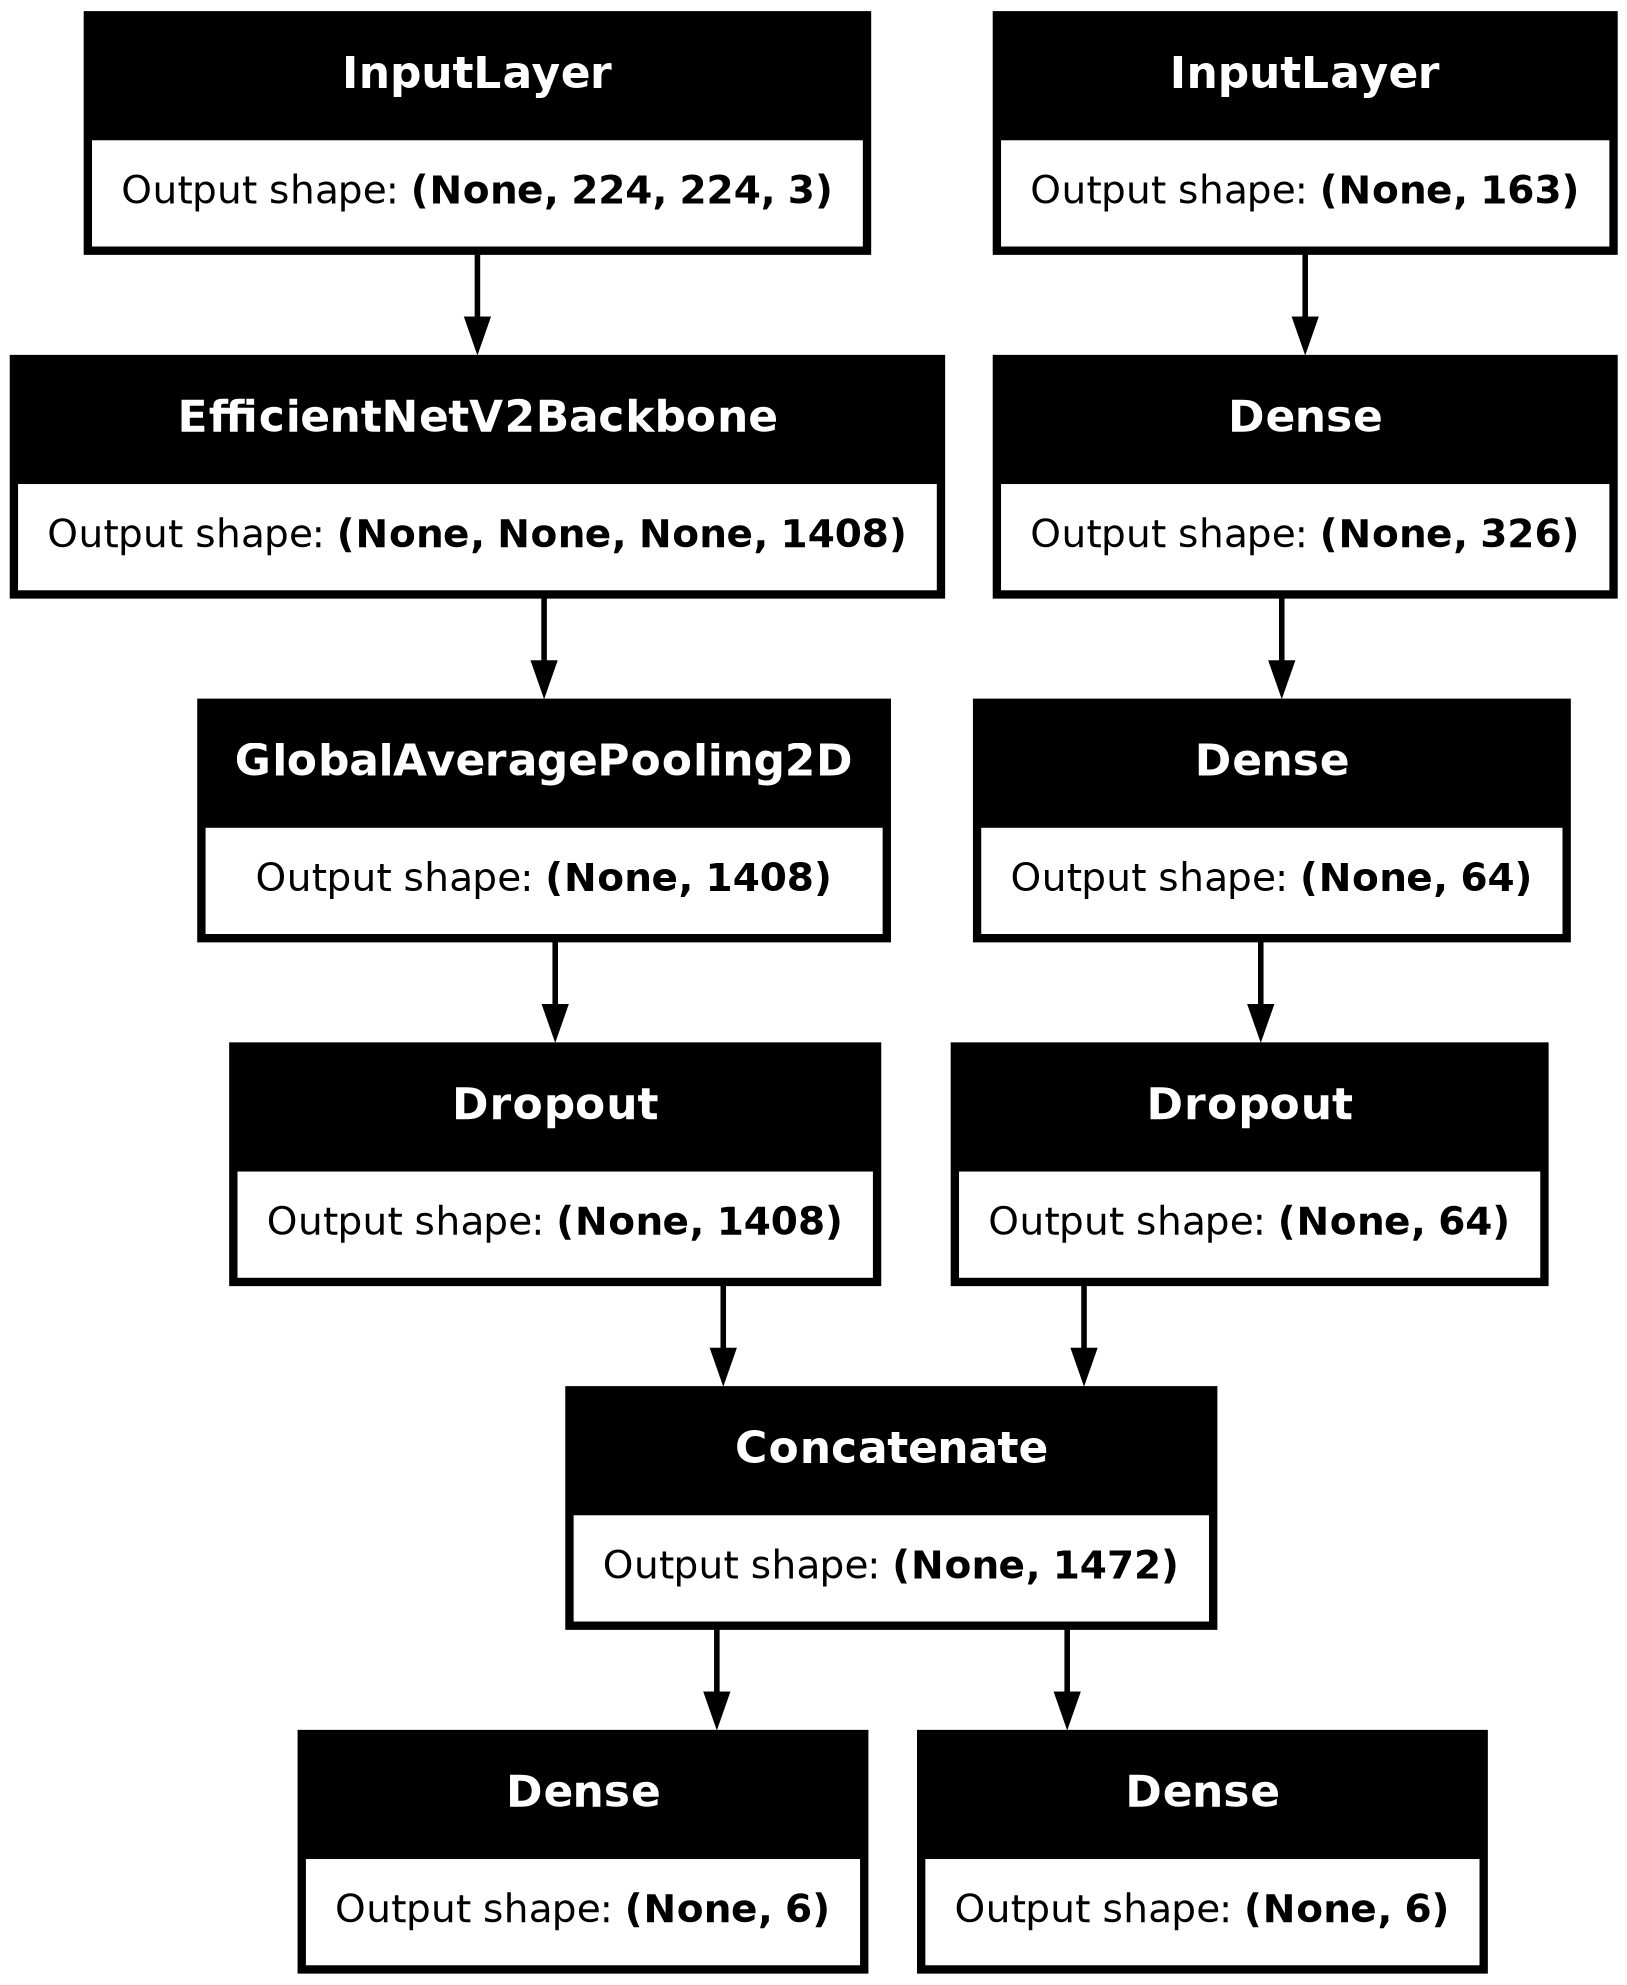

In [14]:
keras.utils.plot_model(model, show_shapes=True)

## Build Test Dataset

Don't forget to normalize for the test data as well.

In [21]:
# Test
test_paths = test_df.image_path.values
test_features = scaler.transform(test_df[FEATURE_COLS].values) 
test_ds = build_dataset(test_paths, test_features, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

## Inference

As our model outputs predictions for two tasks and our submission requires only one, we will take predictions from the main task (`head`) and ignore predictions from the auxiliary task.

In [22]:
preds = model.predict(test_ds)["head"]

145/145 ━━━━━━━━━━━━━━━━━━━━ 105s 678ms/step


# 📩 | Submission

In [23]:
pred_df = test_df[["id"]].copy()
target_cols = [x.replace("_mean","") for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["id"]].copy()
sub_df = sub_df.merge(pred_df, on="id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,id,X4,X11,X18,X26,X50,X3112
0,195066138,-0.099060,1.404266,0.069888,1.254300,-0.025760,121.394836
1,195524180,0.220290,2.242062,2.832736,9.946978,0.370434,151.271317
2,172220512,-0.269862,0.496115,0.083798,4.467178,-0.191250,149.784225
3,195824490,-0.455548,-0.053600,-0.515895,-0.141736,-0.425166,43.501873
4,191793047,-0.314372,0.328862,-0.089717,0.208312,-0.252556,95.088547
